# Gammapy Dark Matter Tutorial

## Gammapy Data Levels

<img src="https://docs.gammapy.org/dev/_images/data-flow-gammapy.png" width="700"/>

Advised Workflow:
1. Produce DL3 data with the `magicDL3` converter (maybe use `automagic` if you start at raw or superstar level)
2. Load into `Gammapy` via `DataStore`
3. Data reduction via `SpectrumDatasetMaker` &rarr; `DL4`
4. Produce science products &rarr; `Upper Limits`

# Let's do some science

### 1. Produce DL3 data

Already done by me, you can find Coma DL3 full-enclosure data here: '/pnfs/pic.es/data/magic/Users/AUTOMAGIC/Stefan/automagic-output/ComaBerenice_2019-01-30_2019-06-04_full-enclosure_Mars-V3-1-0.tar.gz'

### 2. Load via `DataStore`

In [1]:
from gammapy.data import DataStore

In [3]:
ds = DataStore.from_dir('/Users/stefan/Documents/projects/phdthesis/data/ComaBerenice_2019-01-30_2019-06-04_full-enclosure_Mars-V3-1-0/')

In [4]:
ds

**Ignore bad observations due to wrong wobble**: 5079530, 5079531, 5079532, 5079533, 5079534, 5079535

In [5]:
bad_obs = [5079530, 5079531, 5079532, 5079533, 5079534, 5079535]
obs_ids = ds.obs_ids
obs_ids

array([5079268, 5079269, 5079316, 5079317, 5079318, 5079319, 5079320,
       5079362, 5079363, 5079364, 5079365, 5079366, 5079367, 5079426,
       5079427, 5079428, 5079429, 5079441, 5079442, 5079443, 5079497,
       5079498, 5079499, 5079530, 5079531, 5079532, 5079533, 5079534,
       5079535, 5079590, 5079591, 5079592, 5079601, 5079602, 5079603,
       5079668, 5079669, 5079670, 5079703, 5079704, 5079705, 5079706,
       5079707, 5079708, 5079709, 5079716, 5079717, 5079763, 5079764,
       5079765, 5079766, 5079831, 5079832, 5079840, 5079841, 5079872,
       5079879, 5079880, 5079903, 5079904, 5079905, 5079957, 5079958,
       5079969, 5080161, 5080162, 5080163, 5080263, 5080264, 5080265,
       5080266, 5080267, 5080268, 5080269, 5080270, 5080335, 5080384,
       5080385, 5080386, 5080391, 5080392, 5080393, 5080426, 5080427,
       5080432, 5080433, 5080434, 5080439, 5080440, 5080484, 5080485,
       5080486, 5080487, 5080488, 5080489, 5080529, 5080530, 5080537,
       5080538, 5080

In [7]:
import numpy as np

In [8]:
obs_ids = obs_ids[np.all(obs_ids[:,None] != bad_obs, axis=1)]
len(obs_ids)

174

In [9]:
obs = ds.obs(obs_ids[0], required_irf="point-like") # The DL3 data is actually full-enclosure but is missing the bkg
obs

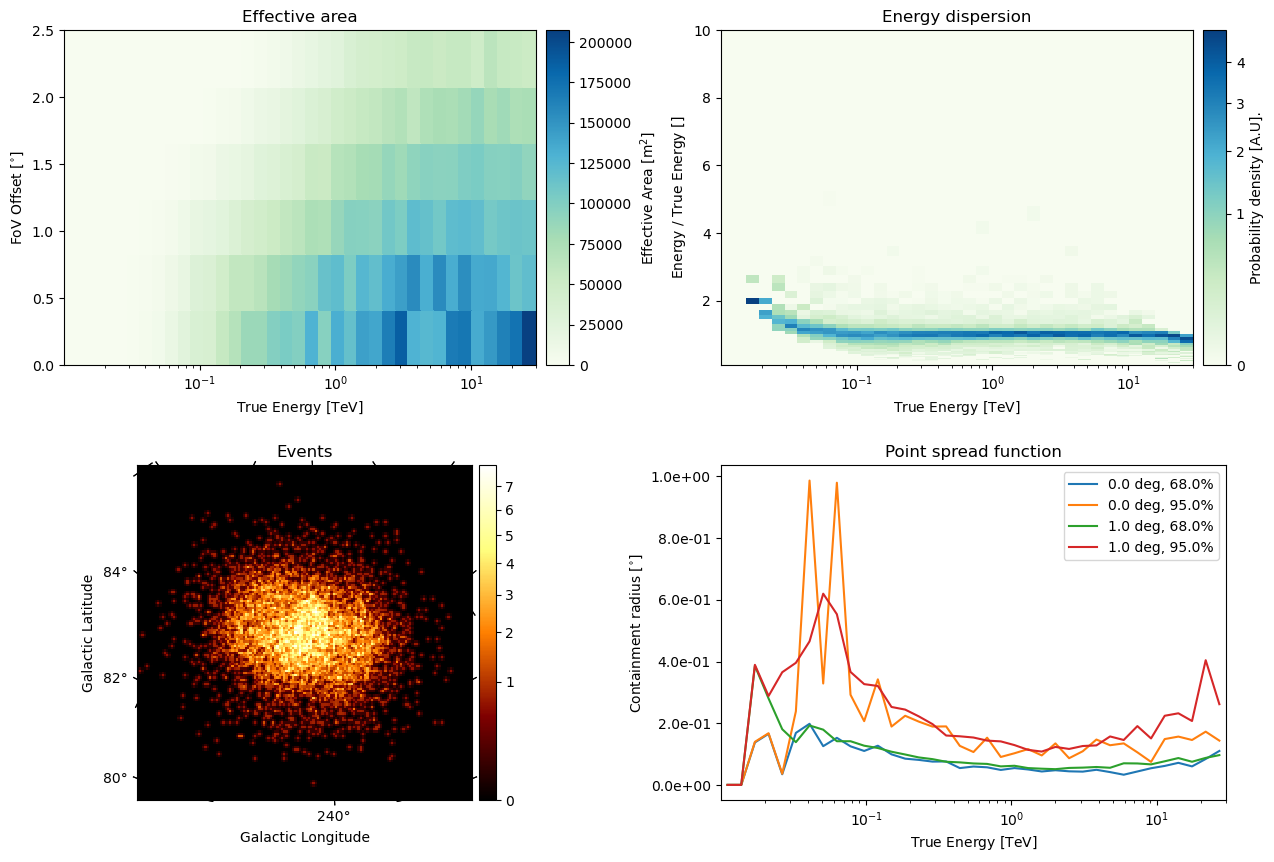

In [10]:
obs.peek()

### 3. Data reduction

In [11]:
from astropy.coordinates import SkyCoord

In [12]:
target_position = SkyCoord.from_name('Coma dwarf')
target_position

<SkyCoord (ICRS): (ra, dec) in deg
    (186.745833, 23.904167)>

In [13]:
import astropy.units as u
from regions import CircleSkyRegion

In [14]:
on_region_radius = u.Quantity('0.17 deg')
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

In [15]:
from gammapy.maps import MapAxis

In [16]:
energy_reco_axis = MapAxis.from_energy_bounds(
    "60GeV", "10TeV", nbin=15, name="energy"
)
energy_true_axis = MapAxis.from_energy_bounds(
    "60GeV", "10TeV", nbin=15, name="energy_true"
)

energy_reco_axis

MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 15        
	node type  : edges     
	edges min  : 6.0e-02 TeV
	edges max  : 1.0e+01 TeV
	interp     : log

In [17]:
from gammapy.maps import RegionGeom

In [18]:
# Combine ON region with energy axis
geom = RegionGeom.create(region=on_region, axes=[energy_reco_axis])
geom

In [19]:
from gammapy.datasets import SpectrumDataset

In [20]:
dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_true_axis, name=f"empty-datset")
dataset_empty

In [21]:
from gammapy.makers import SpectrumDatasetMaker

In [22]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
dataset_maker

In [23]:
from gammapy.makers import ReflectedRegionsBackgroundMaker

In [24]:
# Construct OFF regions
bkg_maker = ReflectedRegionsBackgroundMaker()
bkg_maker

In [25]:
from gammapy.makers import SafeMaskMaker

In [26]:
# safe regions on your dataset
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [30]:
from gammapy.datasets import Datasets
from tqdm import tqdm

In [31]:
datasets = Datasets()
observations = ds.get_observations(obs_ids, required_irf="point-like")

for obs_id, observation in tqdm(zip(obs_ids, observations)):
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

print(datasets)

124it [00:17,  7.17it/s]Effective area is all zero at [186d44m44.9988s 23d54m15.0012s]. No safe energy band can be defined for the dataset '5081424': setting `mask_safe` to all False.
134it [00:19,  6.91it/s]Effective area is all zero at [186d44m44.9988s 23d54m15.0012s]. No safe energy band can be defined for the dataset '5081532': setting `mask_safe` to all False.
153it [00:21,  7.17it/s]Effective area is all zero at [186d44m44.9988s 23d54m15.0012s]. No safe energy band can be defined for the dataset '5081650': setting `mask_safe` to all False.
174it [00:24,  6.98it/s]

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 5079268
  Instrument : Unknown
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 5079269
  Instrument : Unknown
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 5079316
  Instrument : Unknown
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 5079317
  Instrument : Unknown
  Models     : 

Dataset 4: 

  Type       : SpectrumDatasetOnOff
  Name       : 5079318
  Instrument : Unknown
  Models     : 

Dataset 5: 

  Type       : SpectrumDatasetOnOff
  Name       : 5079319
  Instrument : Unknown
  Models     : 

Dataset 6: 

  Type       : SpectrumDatasetOnOff
  Name       : 5079320
  Instrument : Unknown
  Models     : 

Dataset 7: 

  Type       : SpectrumDatasetOnOff
  Name       : 5079362
  Instrument : Unknown
  Models     : 

Dataset 8: 

  Type       : SpectrumDatasetOnOff
  Name       : 5079363
  Instrument 

In [32]:
datasets[0]

In [33]:
stacked = datasets.stack_reduce(name='stacked')

In [34]:
stacked

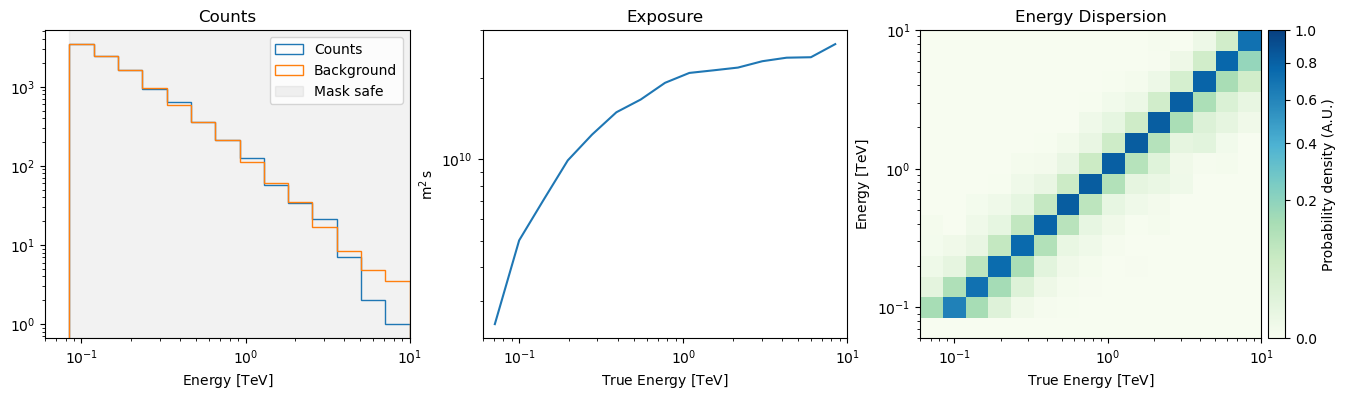

In [35]:
stacked.peek()

### 4. Scienc Products (DL5)

#### Some statistics

Define test statistic as <br> <center>
\begin{align}
    TS &= -2\log{\frac{\mathcal{L}(\mu, \hat{\theta}_\mu)}{\mathcal{L}(\hat{\mu}, \hat{\theta})}}\\
    \mu&, \text{strength parameter}\\
    \hat{\theta}_\mu&, \text{nuisance parameters optimized for } \mu\\
    \hat{\mu}&, \text{best fit strength parameter}\\
    \hat{\theta}&, \text{best fit nuisance parameters}\\
\end{align}

In our case $\mu = \langle\sigma \nu\rangle$ and $\theta = J$!

Gammapy defines Likelihood with the WStat (see [here](https://docs.gammapy.org/dev/user-guide/stats/wstat_derivation.html?highlight=wstat)). <br>
This is already part of the dataset:

In [36]:
stacked.stat_sum() # WStat evaluated with current models (which are None currently)

10.545518695244795

TS follows a $\chi^2$ distribution
\begin{align}
     f(TS) &= \chi^2 \\
\end{align}
Therefore, the detection significance is given by testing against the hypothesis that there is no signal
\begin{align}
     S &= \sqrt{TS(\mu=0)}
\end{align}

Let's assume we want 5$\sigma$. We want to simply check the if $TS(\mu=0) \ge 25$

In [37]:
from gammapy.astro.darkmatter import DarkMatterAnnihilationSpectralModel

In [38]:
dm_model = DarkMatterAnnihilationSpectralModel(mass='1 TeV', channel='b', jfactor='1e19 GeV2 cm-5')
dm_model

\begin{align}
    \frac{\mathrm d \phi}{\mathrm d E} =
    \frac{\text{scale factor }\times \langle \sigma\nu \rangle}{4\pi k m^2_{\mathrm{DM}}}
    \frac{\mathrm d N}{\mathrm dE} \times J(\Delta\Omega)
\end{align}

**Caveat:** J-Factor is not model parameter in Gammapy currently, this is on a specific branch and is work in progress

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='dnde [$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]'>

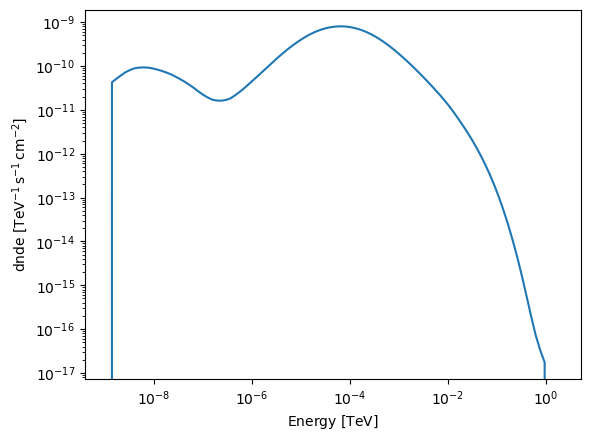

In [39]:
dm_model.plot(energy_bounds=['1 keV', '2 TeV'])

Text(0.5, 1.0, 'Example of a Test Statistic, Discovery')

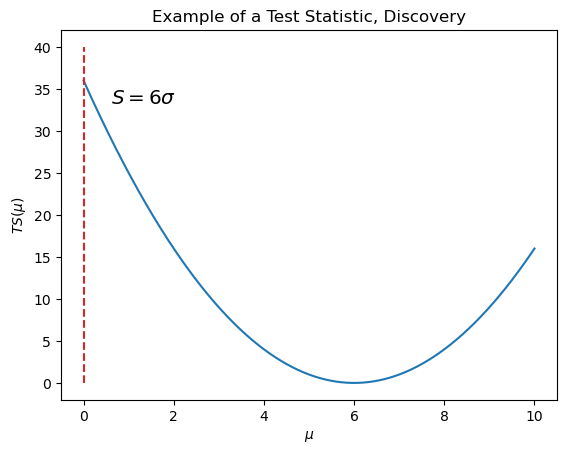

In [40]:
# For visualization purposes
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 1000)
f, ax = plt.subplots()
plt.plot(x, (x-6)**2)
plt.vlines(0, 0, 40, color='tab:red', ls='--')
plt.text(0.1, 0.8, r'$S = 6\sigma$', transform=ax.transAxes, size='x-large')
plt.ylabel(r'$TS(\mu)$')
plt.xlabel(r'$\mu$')
plt.title('Example of a Test Statistic, Discovery')

No detection &#x1F613;? Let's calculate some Upper Limits &#x1F91D;

Same procedure, but this time we searching for the right $\mu$
\begin{align}
    CL &= 95\% \\
    p &= 0.05\\
    TS(\mu) &\stackrel{!}{=} 1 - CDF_{\chi^2}(2\times p) = 2.71\\
\end{align}

In [41]:
from scipy.stats import chi2
chi2.isf(2*0.05, df=1)

2.7055434540954173

Text(0.5, 1.0, 'Example of a Test Statistic, Upper Limit')

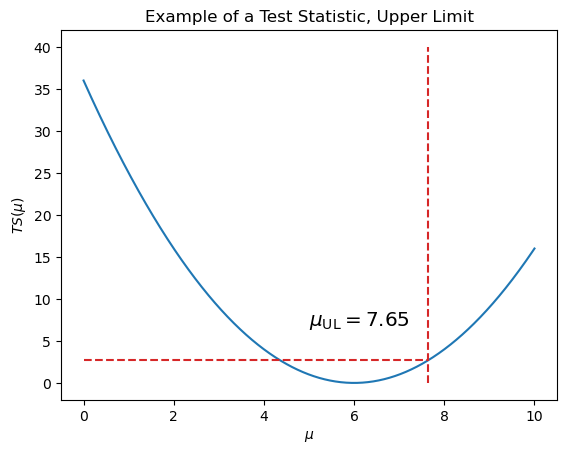

In [42]:
# For visualization purposes
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 1000)
f, ax = plt.subplots()
plt.plot(x, (x-6)**2)
plt.vlines(np.sqrt(2.71) + 6, 0, 40, color='tab:red', ls='--')
plt.hlines(2.71, 0, np.sqrt(2.71) + 6, color='tab:red', ls='--')
plt.text(0.5, 0.2, rf'$\mu_\text{{UL}} = {np.sqrt(2.71) + 6:.2f}$', transform=ax.transAxes, size='x-large')
plt.ylabel(r'$TS(\mu)$')
plt.xlabel(r'$\mu$')
plt.title('Example of a Test Statistic, Upper Limit')

##### 

#### Very simple Upper Limits

In [43]:
from gammapy.modeling.models import SkyModel

In [44]:
model = SkyModel(spectral_model=dm_model, name="dm_model")

In [45]:
stacked.models = model

In [46]:
print(stacked)

SpectrumDatasetOnOff
--------------------

  Name                            : stacked 

  Total counts                    : 9932 
  Total background counts         : 9872.50
  Total excess counts             : 59.50

  Predicted counts                : 9881.44
  Predicted background counts     : 9880.93
  Predicted excess counts         : 0.51

  Exposure min                    : 2.46e+09 m2 s
  Exposure max                    : 2.67e+10 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 14 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10.54

  Number of models                : 1 
  Number of parameters            : 2
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : dm_model
    Datasets names            : None
    Spectral model type       : DarkMatterAnnihilationSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      scale   

In [47]:
from gammapy.modeling import Fit

In [48]:
stacked.models.parameters['jfactor'].frozen = True # no nuisance parameters
stacked.models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str1,str7,float64,str9,float64,float64,float64,bool,bool,str1,str1
,scale,1.0000e+00,,0.000e+00,nan,nan,False,True,,
,jfactor,1.0000e+19,GeV2 cm-5,0.000e+00,nan,nan,True,False,,


In [49]:
fit = Fit()
fit_result = fit.run(stacked)
mu_best = fit_result.parameters['scale'].value
likelihood_minimum = stacked.stat_sum()
print(mu_best, likelihood_minimum)

55.829257209783925 10.467123182309564


In [50]:
print(stacked)

SpectrumDatasetOnOff
--------------------

  Name                            : stacked 

  Total counts                    : 9932 
  Total background counts         : 9872.50
  Total excess counts             : 59.50

  Predicted counts                : 9905.61
  Predicted background counts     : 9876.90
  Predicted excess counts         : 28.71

  Exposure min                    : 2.46e+09 m2 s
  Exposure max                    : 2.67e+10 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 14 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10.47

  Number of models                : 1 
  Number of parameters            : 2
  Number of free parameters       : 1

  Component 0: SkyModel
  
    Name                      : dm_model
    Datasets names            : None
    Spectral model type       : DarkMatterAnnihilationSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      scale  

**Find the $\mu$ for $TS=2.71$!**

In [51]:
stacked.models['dm_model'].spectral_model.scale.scan_values = np.linspace(mu_best-1000, 1000, 1000)

In [52]:
stat_profile = fit.stat_profile(stacked, 'scale')
stat_profile

{'dm_model.spectral.scale_scan': array([-9.44170743e+02, -9.42224626e+02, -9.40278509e+02, -9.38332392e+02,
        -9.36386275e+02, -9.34440158e+02, -9.32494042e+02, -9.30547925e+02,
        -9.28601808e+02, -9.26655691e+02, -9.24709574e+02, -9.22763457e+02,
        -9.20817340e+02, -9.18871224e+02, -9.16925107e+02, -9.14978990e+02,
        -9.13032873e+02, -9.11086756e+02, -9.09140639e+02, -9.07194522e+02,
        -9.05248406e+02, -9.03302289e+02, -9.01356172e+02, -8.99410055e+02,
        -8.97463938e+02, -8.95517821e+02, -8.93571704e+02, -8.91625588e+02,
        -8.89679471e+02, -8.87733354e+02, -8.85787237e+02, -8.83841120e+02,
        -8.81895003e+02, -8.79948886e+02, -8.78002770e+02, -8.76056653e+02,
        -8.74110536e+02, -8.72164419e+02, -8.70218302e+02, -8.68272185e+02,
        -8.66326068e+02, -8.64379952e+02, -8.62433835e+02, -8.60487718e+02,
        -8.58541601e+02, -8.56595484e+02, -8.54649367e+02, -8.52703250e+02,
        -8.50757134e+02, -8.48811017e+02, -8.46864900e+0

(0.0, 0.001)

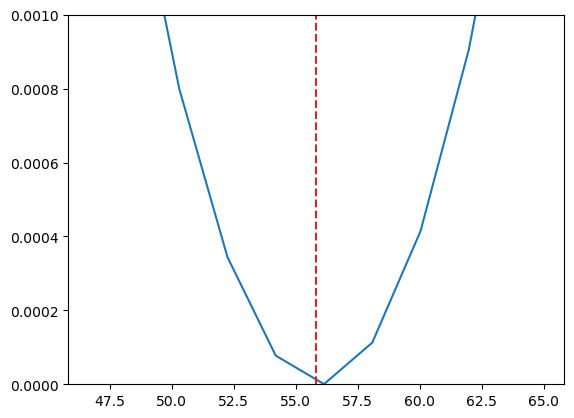

In [53]:
plt.plot(stat_profile['dm_model.spectral.scale_scan'], stat_profile['stat_scan']-likelihood_minimum)
plt.xlim(mu_best - 10,mu_best+10)
plt.vlines(mu_best, 0, 1e-3, color='tab:red', ls='--')
plt.ylim(0,1e-3)

**Best fit is negativ &rarr; redefine TS for unphysical values!**

\begin{align}
    TS &= \begin{cases}
        -2\log{\frac{\mathcal{L}(\mu, \hat{\theta}_\mu)}{\mathcal{L}(\hat{\mu}, \hat{\theta})}}, \mu \ge 0\\
        -2\log{\frac{\mathcal{L}(\mu, \hat{\theta}_\mu)}{\mathcal{L}(0, \hat{\theta})}}, \mu \lt 0
    \end{cases}
\end{align}

In [54]:
from scipy.interpolate import interp1d

In [55]:
likelihood = interp1d(stat_profile['dm_model.spectral.scale_scan'], stat_profile['stat_scan'], kind="quadratic", fill_value="extrapolate")

In [56]:
def ts(mu):
    return likelihood(mu) - likelihood(0) # mu < 0 case

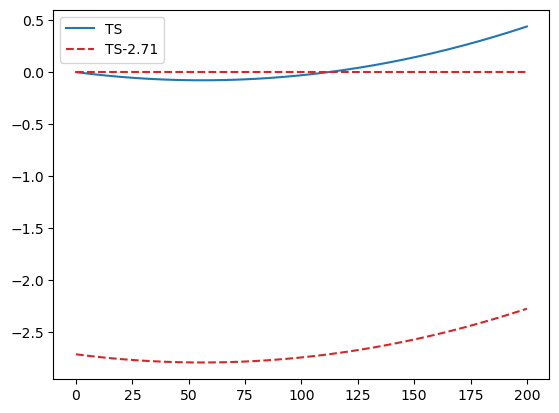

In [57]:
x = np.linspace(0, 200, 1000)
plt.plot(x, ts(x), label='TS')
plt.plot(x, ts(x)-2.71, color='tab:red', ls='--', label='TS-2.71')
plt.hlines(0, 0, 200, color='tab:red', ls='--')
plt.legend()

In [58]:
from scipy.optimize import brentq

In [59]:
ul = brentq(lambda x: ts(x)-2.71, 0, 1000, maxiter=100, rtol=1e-5)
ul

391.46127758728477

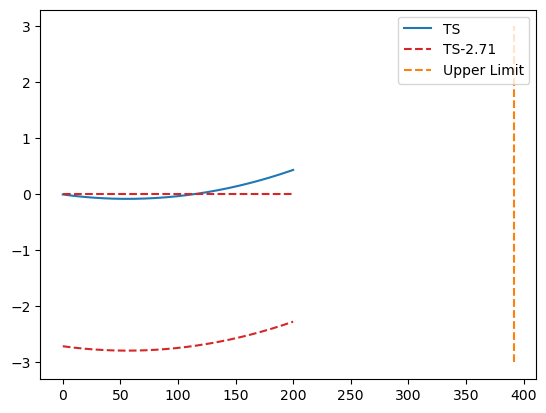

In [60]:
x = np.linspace(0, 200, 1000)
plt.plot(x, ts(x), label='TS')
plt.plot(x, ts(x)-2.71, color='tab:red', ls='--', label='TS-2.71')
plt.hlines(0, 0, 200, color='tab:red', ls='--')
plt.vlines(ul, -3, 3, color='tab:orange', ls='--', label='Upper Limit')
plt.legend()

Finally, multiply scale value with thermal relic cross-section:

In [61]:
sigmav = ul * dm_model.THERMAL_RELIC_CROSS_SECTION
sigmav

<Quantity 1.17438383e-23 cm3 / s>

#### Do it in a loop

Interested in Upper Limits in dependence of the mass for a specific channel!

In [62]:
def ts(likelihood_fnc, likelihood_minimum ,mu):
        return likelihood_fnc(mu) - likelihood_minimum

In [63]:
masses = np.geomspace(1e-1, 1e2, 30) * u.TeV
masses

<Quantity [  0.1       ,   0.1268961 ,   0.1610262 ,   0.20433597,
             0.25929438,   0.32903446,   0.41753189,   0.52983169,
             0.67233575,   0.85316785,   1.08263673,   1.3738238 ,
             1.74332882,   2.21221629,   2.8072162 ,   3.56224789,
             4.52035366,   5.73615251,   7.27895384,   9.23670857,
            11.72102298,  14.87352107,  18.87391822,  23.9502662 ,
            30.39195382,  38.56620421,  48.93900918,  62.10169419,
            78.80462816, 100.        ] TeV>

In [65]:
uls = []
for mass in masses:
    d = stacked.copy()
    dm_model = DarkMatterAnnihilationSpectralModel(mass=mass, channel='b', jfactor='1e19 GeV2 cm-5')
    dm_model.jfactor.frozen = True
    model = SkyModel(spectral_model=dm_model, name=f"dm_{mass:.2f}", datasets_names=d.name)

    d.models = model # assign model to dataset

    
    

    fit = Fit()
    fit_result = fit.run(d)
    mu_best = fit_result.parameters['scale'].value
    likelihood_minimum = d.stat_sum() 
    
    if mu_best < 0:
        mu_best = 1e-3
        d.models.parameters['scale'].value = 0
        likelihood_minimum = d.stat_sum()
        
        

    # rough scan of TS to find region of interest
    found_upper_bound = False
    upper_bound = mu_best
    while not found_upper_bound:
        d.models.parameters['scale'].scan_values = [upper_bound]
        stats = fit.stat_profile(d, 'scale')

        current_ts = stats["stat_scan"] - likelihood_minimum
        if current_ts > 2.71:
            found_upper_bound = True
        else:
            upper_bound *= 2
        


    d.models[f'dm_{mass:.2f}'].spectral_model.scale.scan_values = np.linspace(upper_bound/2, upper_bound, 100)
    
    stat_profile = fit.stat_profile(d, 'scale')

    likelihood_fnc = interp1d(stat_profile[f'dm_{mass:.2f}.spectral.scale_scan'], stat_profile['stat_scan'], kind="quadratic")
    ul = brentq(lambda mu: ts(likelihood_fnc, likelihood_minimum, mu)-2.71, upper_bound/2, upper_bound, maxiter=100, rtol=1e-5)
    
    uls.append(ul)

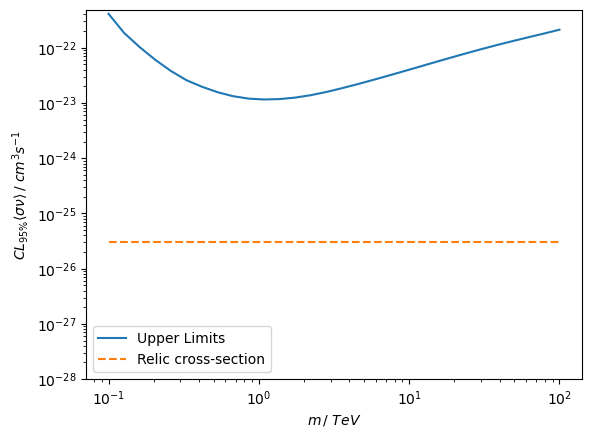

In [66]:
plt.plot(masses, np.array(uls) * dm_model.THERMAL_RELIC_CROSS_SECTION, label='Upper Limits')
plt.yscale('log')
plt.hlines(dm_model.THERMAL_RELIC_CROSS_SECTION.value, np.min(masses.value), np.max(masses.value), color='tab:orange', ls='dashed', label='Relic cross-section')
plt.xscale('log')
plt.ylim(1e-28,)
plt.ylabel(r'$CL_{95\%} \langle\sigma\nu\rangle \,/\ cm^3 s^{-1}$')
plt.xlabel(r'$m \,/\ TeV$')
plt.legend()
plt.show()

#### Null Sensitivity

Calculate the sensitiviy for Upper Limits: Generate Null dataset, which only contain background

In [69]:
uls_runs = []
runs = range(100)
null = stacked.copy()
for run in tqdm(runs):
    null.fake(null.counts)
    uls = []
    for mass in masses:
        d = null.copy()
        dm_model = DarkMatterAnnihilationSpectralModel(mass=mass, channel='b', jfactor="1e19 GeV2 cm-5")
        dm_model.jfactor.frozen = True
        model = SkyModel(spectral_model=dm_model, name=f"dm_{mass:.2f}", datasets_names=d.name)
    
        d.models = model # assign model to dataset
        
        
    
        fit = Fit()
        fit_result = fit.run(d)
        mu_best = fit_result.parameters['scale'].value
        likelihood_minimum = d.stat_sum() 
        
        if mu_best < 0:
            mu_best = 1e-3
            d.models.parameters['scale'].value = 0
            likelihood_minimum = d.stat_sum()
            
            
    
        # rough scan of TS to find region of interest
        found_upper_bound = False
        upper_bound = mu_best
        while not found_upper_bound:
            d.models.parameters['scale'].scan_values = [upper_bound]
            stats = fit.stat_profile(d, 'scale')
    
            current_ts = stats["stat_scan"] - likelihood_minimum
            if current_ts > 2.71:
                found_upper_bound = True
            else:
                upper_bound *= 2
        
    
        d.models[f'dm_{mass:.2f}'].spectral_model.scale.scan_values = np.linspace(upper_bound/2, upper_bound, 100)
        
        stat_profile = fit.stat_profile(d, 'scale')
    
        likelihood_fnc = interp1d(stat_profile[f'dm_{mass:.2f}.spectral.scale_scan'], stat_profile['stat_scan'], kind="quadratic")
        ul = brentq(lambda mu: ts(likelihood_fnc, likelihood_minimum, mu)-2.71, upper_bound/2, upper_bound, maxiter=100, rtol=1e-5)
        
        uls.append(ul)
    uls_runs.append(uls)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:11<00:00,  5.51s/it]


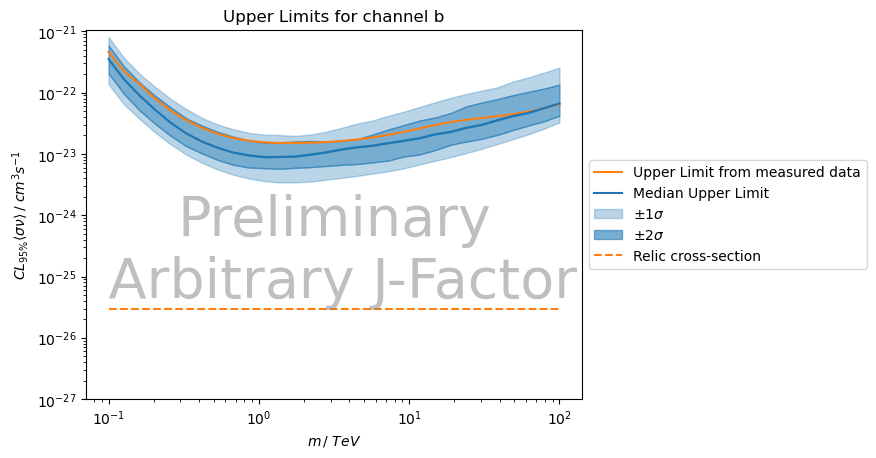

In [71]:
from scipy.stats import norm
fig, ax = plt.subplots()
med = np.median(uls_runs, axis=0) * dm_model.THERMAL_RELIC_CROSS_SECTION
minus_2 = np.percentile(uls_runs, norm.cdf(-2)*100, axis=0) * dm_model.THERMAL_RELIC_CROSS_SECTION
minus_1 = np.percentile(uls_runs, norm.cdf(-1)*100, axis=0) * dm_model.THERMAL_RELIC_CROSS_SECTION
plus_1 = np.percentile(uls_runs, norm.cdf(1)*100, axis=0) * dm_model.THERMAL_RELIC_CROSS_SECTION
plus_2 = np.percentile(uls_runs, norm.cdf(2)*100, axis=0) * dm_model.THERMAL_RELIC_CROSS_SECTION

plt.plot(masses, uls*dm_model.THERMAL_RELIC_CROSS_SECTION, color='tab:orange', label='Upper Limit from measured data')
plt.plot(masses, med, label='Median Upper Limit')
plt.fill_between(masses.value, minus_2.value, minus_1.value, color="tab:blue", alpha=0.3, label=r'$\pm 1\sigma$')
plt.fill_between(masses.value, minus_1.value, med.value, color="tab:blue", alpha=0.6, label=r'$\pm 2\sigma$')
plt.fill_between(masses.value, med.value, plus_1.value, color="tab:blue", alpha=0.6)
plt.fill_between(masses.value, plus_1.value, plus_2.value, color="tab:blue", alpha=0.3)
plt.yscale('log')
plt.hlines(dm_model.THERMAL_RELIC_CROSS_SECTION.value, np.min(masses.value), np.max(masses.value), color='tab:orange', linestyle='dashed', label='Relic cross-section')
plt.xscale('log')
plt.ylim(1e-27,)
plt.text(0.5, 0.4, 'Preliminary\n Arbitrary J-Factor', transform=ax.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center', rotation=0)
plt.ylabel(r'$CL_{95\%} \langle\sigma\nu\rangle \,/\ cm^3 s^{-1}$')
plt.xlabel(r'$m \,/\ TeV$')
plt.title('Upper Limits for channel b')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Extra: J-Factor as Nuisance Parameter

**Caveat**: Again, this is currently not possible with Gammapy v1.1 (or v1.2)

In [72]:
from gammapy.modeling.models import GaussianPrior

In [73]:
GaussianPrior()

Add this to the J-Factor

In [74]:
dm_model.jfactor.prior = GaussianPrior(mu=1e19, sigma=1e18)
dm_model

In [76]:
uls_runs_prior = []
runs = range(10)
null = stacked.copy()
for run in tqdm(runs):
    null.fake(null.counts)
    uls = []
    for mass in masses:
        d = null.copy()
        dm_model = DarkMatterAnnihilationSpectralModel(mass=mass, channel='b', jfactor="1e19 GeV2 cm-5")
        dm_model.jfactor.prior = GaussianPrior(mu=1e19, sigma=1e18) # add prior instead of freezing the j-factor
        model = SkyModel(spectral_model=dm_model, name=f"dm_{mass:.2f}", datasets_names=d.name)
    
        d.models = model # assign model to dataset
        
        
    
        fit = Fit()
        fit_result = fit.run(d)
        mu_best = fit_result.parameters['scale'].value
        likelihood_minimum = d.stat_sum() 
        
        if mu_best < 0:
            mu_best = 1e-3
            d.models.parameters['scale'].value = 0
            likelihood_minimum = d.stat_sum()
            
            
    
        # rough scan of TS to find region of interest
        found_upper_bound = False
        upper_bound = mu_best
        while not found_upper_bound:
            d.models.parameters['scale'].scan_values = [upper_bound]
            stats = fit.stat_profile(d, 'scale', reoptimize=True) # reoptimize to fit J-factor for given mu
    
            current_ts = stats["stat_scan"] - likelihood_minimum
            if current_ts > 2.71:
                found_upper_bound = True
            else:
                upper_bound *= 2
        
    
        d.models[f'dm_{mass:.2f}'].spectral_model.scale.scan_values = np.linspace(upper_bound/2, upper_bound, 100)
        
        stat_profile = fit.stat_profile(d, 'scale', reoptimize=True)
    
        likelihood_fnc = interp1d(stat_profile[f'dm_{mass:.2f}.spectral.scale_scan'], stat_profile['stat_scan'], kind="quadratic")
        ul = brentq(lambda mu: ts(likelihood_fnc, likelihood_minimum, mu)-2.71, upper_bound/2, upper_bound, maxiter=100, rtol=1e-5)
        
        uls.append(ul)
    uls_runs_prior.append(uls)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:42<00:00, 70.25s/it]


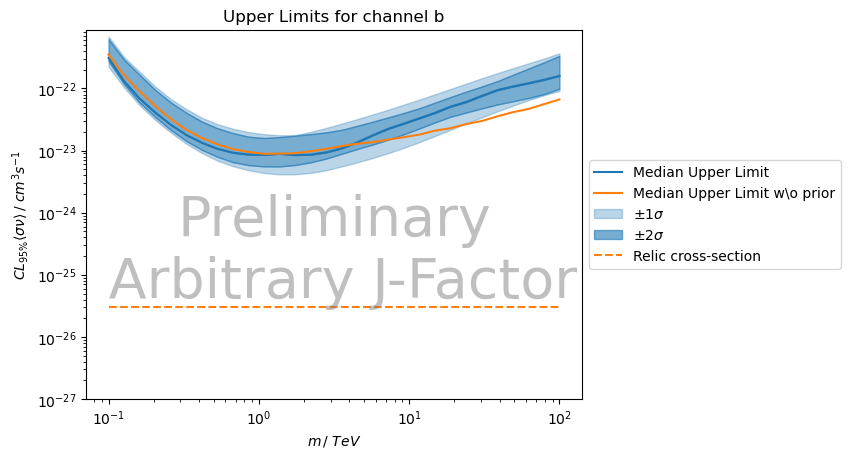

In [77]:
from scipy.stats import norm
fig, ax = plt.subplots()
med = np.median(uls_runs_prior, axis=0) * dm_model.THERMAL_RELIC_CROSS_SECTION
med_wo_prior = np.median(uls_runs, axis=0) * dm_model.THERMAL_RELIC_CROSS_SECTION
minus_2 = np.percentile(uls_runs_prior, norm.cdf(-2)*100, axis=0) * dm_model.THERMAL_RELIC_CROSS_SECTION
minus_1 = np.percentile(uls_runs_prior, norm.cdf(-1)*100, axis=0) * dm_model.THERMAL_RELIC_CROSS_SECTION
plus_1 = np.percentile(uls_runs_prior, norm.cdf(1)*100, axis=0) * dm_model.THERMAL_RELIC_CROSS_SECTION
plus_2 = np.percentile(uls_runs_prior, norm.cdf(2)*100, axis=0) * dm_model.THERMAL_RELIC_CROSS_SECTION


plt.plot(masses, med, label='Median Upper Limit')
plt.plot(masses, med_wo_prior, label='Median Upper Limit w\o prior', color='tab:orange')
plt.fill_between(masses.value, minus_2.value, minus_1.value, color="tab:blue", alpha=0.3, label=r'$\pm 1\sigma$')
plt.fill_between(masses.value, minus_1.value, med.value, color="tab:blue", alpha=0.6, label=r'$\pm 2\sigma$')
plt.fill_between(masses.value, med.value, plus_1.value, color="tab:blue", alpha=0.6)
plt.fill_between(masses.value, plus_1.value, plus_2.value, color="tab:blue", alpha=0.3)
plt.yscale('log')
plt.hlines(dm_model.THERMAL_RELIC_CROSS_SECTION.value, np.min(masses.value), np.max(masses.value), color='tab:orange', linestyle='dashed', label='Relic cross-section')
plt.xscale('log')
plt.ylim(1e-27,)
plt.text(0.5, 0.4, 'Preliminary\n Arbitrary J-Factor', transform=ax.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center', rotation=0)
plt.ylabel(r'$CL_{95\%} \langle\sigma\nu\rangle \,/\ cm^3 s^{-1}$')
plt.xlabel(r'$m \,/\ TeV$')
plt.title('Upper Limits for channel b')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()